In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import numpy as np

In [112]:
df = pd.read_csv('reviews (1).csv')

In [113]:
df= df[df.columns[2:]]

In [114]:
df.loc[:, df.columns != 'Title']

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...
23481,34,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,31,"This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,28,I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [115]:
df.dropna(inplace=True)

In [116]:
len(df)

19662

In [117]:
import re
import string

def to_lowercase(tweet):
  tweet = tweet.lower()
  return tweet

def word_repetition(tweet):
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
  return tweet

def punct_repetition(tweet, default_replace=""):
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, tweet)
  return tweet

import contractions
def fix_contractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize(tweet):
  tokens = word_tokenize(tweet)
  return tokens

from nltk.corpus import stopwords
nltk.download('stopwords')



def custom_tokenize(line,
                    keep_punct = False,
                    keep_alnum = False,
                    keep_stop = False):
  
  token_list = word_tokenize(line)

  if not keep_punct:
    token_list = [token for token in token_list
                  if token not in string.punctuation]

  if not keep_alnum:
    token_list = [token for token in token_list if token.isalpha()]
  
  if not keep_stop:
    stop_words = nltk.corpus.stopwords.words('english')
    token_list = [token for token in token_list if not token in stop_words]

  return token_list


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diefa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
def process(line):
    if type(line)!=float:
        ## Word Features
        line = to_lowercase(line) # lower case
        line = fix_contractions(line) # replace contractions
        line = punct_repetition(line) # replace punctuation repetition
        line = word_repetition(line) # replace word repetition
        ## Tokenization & Stemming
        tokens = custom_tokenize(line, keep_alnum=False, keep_stop=False)
    
    return tokens

In [164]:

# Paso 3: Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=2)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=2)

In [166]:
clean_train = []

for i in train_data['Review Text']:
    clean_train.append(process(i))

clean_val = []
for i in val_data['Review Text']:
    clean_val.append(process(i))

clean_test = []
for i in test_data['Review Text']:
    clean_test.append(process(i))

In [167]:
w = []
for t in clean_train:
    w.extend(t)

In [370]:
# Crear un conjunto de vocabulario único
vocab = set(w)
vocab.add('<UNK>')
# Crear un diccionario de vocabulario con índices asignados a cada palabra
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}
word_to_idx['<UNK>'] = 0


In [170]:
len(word_to_idx)

10971

In [371]:
# Función para convertir palabras en números según el diccionario
def convertir_a_numeros(sublista, diccionario):
    return [diccionario.get(palabra,diccionario['<UNK>']) for palabra in sublista]

# Convertir cada sublista
sequence_train = [convertir_a_numeros(sublista, word_to_idx) for sublista in clean_train]
sequence_val = [convertir_a_numeros(sublista, word_to_idx) for sublista in clean_val]
sequence_test = [convertir_a_numeros(sublista, word_to_idx) for sublista in clean_test]


In [372]:
maximo = 0
for i in sequence_train:
    if len(i) > maximo:
        maximo = len(i)
maximo

    

57

In [373]:
# Función para ajustar la longitud de las sublistas
def ajustar_longitud(sublista, longitud_deseada):
    if len(sublista) < longitud_deseada:
        return [0] * (longitud_deseada - len(sublista)) + sublista
    else:
        return sublista[:longitud_deseada]

# Ajustar la longitud de todas las sublistas
sequence_adj_train = [ajustar_longitud(sublista, 57) for sublista in sequence_train]
sequence_adj_val = [ajustar_longitud(sublista, 57) for sublista in sequence_val]
sequence_adj_test = [ajustar_longitud(sublista, 57) for sublista in sequence_test]

In [175]:
# Creamos una instancia de LabelEncoder
label_encoder = LabelEncoder()

In [176]:
train_data['Division Name'] = label_encoder.fit_transform(train_data['Division Name'])
val_data['Division Name'] = label_encoder.transform(val_data['Division Name'])
test_data['Division Name'] = label_encoder.transform(test_data['Division Name'])


In [177]:
train_data['Department Name'] = label_encoder.fit_transform(train_data['Department Name'])
val_data['Department Name'] = label_encoder.transform(val_data['Department Name'])
test_data['Department Name'] = label_encoder.transform(test_data['Department Name'])


In [178]:
train_data['Class Name'] = label_encoder.fit_transform(train_data['Class Name'])
val_data['Class Name'] = label_encoder.transform(val_data['Class Name'])
test_data['Class Name'] = label_encoder.transform(test_data['Class Name'])


In [374]:
train_data['Sequence'] = sequence_adj_train
val_data['Sequence'] = sequence_adj_val
test_data['Sequence'] = sequence_adj_test

In [355]:
class CustomDataset(Dataset):
    def __init__(self, texts, ages, recomends, positives, divisions, departments, class_ns, targets):
        self.texts = texts
        self.age = ages
        self.recomend = recomends
        self.positive = positives
        self.division = divisions
        self.department = departments
        self.class_n = class_ns
        self.targets = np.array(targets) - 1

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        text = self.texts[idx]

        numeric = torch.from_numpy(np.array([self.age[idx], self.recomend[idx], self.positive[idx], self.division[idx],
                                           self.department[idx], self.class_n[idx]]))
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return torch.from_numpy(np.array(text)), numeric, target

In [185]:
train_data.columns

Index(['Age', 'Title', 'Review Text', 'Rating', 'Recommended IND',
       'Positive Feedback Count', 'Division Name', 'Department Name',
       'Class Name', 'Sequence'],
      dtype='object')

In [197]:
train_data.reset_index(drop=True, inplace=True)
train_data.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sequence
0,25,Runs big,This dress looks so cute in the pictures-i lov...,2,0,0,0,1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,42,Nice dress for work or a date,Bought this dress based on the other reviews a...,5,1,0,1,1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,37,So comfortable,"I love the style of this dress, comfortable bu...",5,1,0,1,1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,28,"Shrinks, shrinks, shrinks",I purchased this top in the rose and steel blu...,1,0,1,0,4,8,"[0, 0, 0, 0, 0, 0, 0, 8782, 1742, 7638, 3197, ..."
4,54,Gorgeous but not for me,I was so excited about this dress. but when i ...,4,1,0,0,1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [375]:
Train_Dataset = CustomDataset(train_data['Sequence'].to_list(), train_data['Age'].to_list(), 
                              train_data['Recommended IND'].to_list(), 
                              train_data['Positive Feedback Count'].to_list(),
                              train_data['Division Name'].to_list(),
                              train_data['Department Name'].to_list(),
                              train_data['Class Name'].to_list(),
                              train_data[ 'Rating'].to_list())

In [376]:
Val_Dataset = CustomDataset(val_data['Sequence'].to_list(), val_data['Age'].to_list(), 
                              val_data['Recommended IND'].to_list(), 
                              val_data['Positive Feedback Count'].to_list(),
                              val_data['Division Name'].to_list(),
                              val_data['Department Name'].to_list(),
                              val_data['Class Name'].to_list(),
                              val_data[ 'Rating'].to_list())

In [377]:
Test_Dataset = CustomDataset(test_data['Sequence'].to_list(), test_data['Age'].to_list(), 
                              test_data['Recommended IND'].to_list(), 
                              test_data['Positive Feedback Count'].to_list(),
                              test_data['Division Name'].to_list(),
                              test_data['Department Name'].to_list(),
                              test_data['Class Name'].to_list(),
                              test_data[ 'Rating'].to_list())

In [378]:
next(iter(Val_Dataset))

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0, 7128,  831, 6481, 5134,
         2088, 9251, 7755, 4295, 8324, 2505, 4668, 4285, 7755],
        dtype=torch.int32),
 tensor([39,  1,  1,  0,  4,  4], dtype=torch.int32),
 tensor(3))

In [379]:
train_loader = DataLoader(Train_Dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(Val_Dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(Test_Dataset,batch_size=64, shuffle=False)

In [380]:
class RNNModel(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_numeric_features):
        super(RNNModel, self).__init__()
        self.relu = nn.ReLU()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size + num_numeric_features, 64)
        self.fc2 = nn.Linear(64, 5)

    def forward(self, text, numeric):
        embedded = self.embedding(text)
        output, _ = self.rnn(embedded)
        output = output[:, -1, :]  # Tomar solo la última salida de la secuencia
        combined = torch.cat((output, numeric), dim=1)
        output = self.fc1(combined)
        output = self.relu(output)
        output = self.fc2(output)
        return output

In [381]:
# Parámetros del modelo
input_size = 57
hidden_size = 128
num_layers = 1
output_size = 1


In [363]:
len(vocab)

10971

In [383]:
import torch

input_size = len(vocab)+1  # Tamaño del vocabulario
embedding_dim = 30  # Dimensión del embedding
hidden_size = 64  # Tamaño del estado oculto de la RNN
num_layers = 2  # Número de capas de la RNN
num_numeric_features = 6  # Número de características numéricas

model = RNNModel(input_size, embedding_dim, hidden_size, num_layers, num_numeric_features)



tensor([[-0.8272, -0.7467, -2.3205,  2.8773,  0.0962]],
       grad_fn=<AddmmBackward0>)


In [384]:
seq, num, targ =next(iter(train_loader))

In [385]:
seq.shape

torch.Size([64, 57])

In [386]:
seq.unsqueeze(0).shape

torch.Size([1, 64, 57])

In [387]:
len(train_data['Rating'].unique())

5

In [388]:
model(seq, num).shape

torch.Size([64, 5])

In [389]:
# Definir la función de pérdida y el optimizador
# Definir hiperparámetros
learning_rate = 0.001
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#

# Función Training Básica

In [390]:
def training(criterion, optimizer, model, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            sequence, numeric, target = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(sequence, numeric)

            # For classification
            loss = criterion(output, target)
            running_loss += loss.item()

            loss.backward()

            # Update the parameters
            optimizer.step()

        # Print the epoch loss
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}")

In [391]:
training(criterion,optimizer,model,train_loader, 30)

Epoch 1, Loss: 1.230
Epoch 2, Loss: 0.969
Epoch 3, Loss: 0.851
Epoch 4, Loss: 0.786
Epoch 5, Loss: 0.744
Epoch 6, Loss: 0.711
Epoch 7, Loss: 0.682
Epoch 8, Loss: 0.658
Epoch 9, Loss: 0.634
Epoch 10, Loss: 0.595
Epoch 11, Loss: 0.561
Epoch 12, Loss: 0.523
Epoch 13, Loss: 0.479
Epoch 14, Loss: 0.435
Epoch 15, Loss: 0.385
Epoch 16, Loss: 0.342
Epoch 17, Loss: 0.306
Epoch 18, Loss: 0.294
Epoch 19, Loss: 0.284
Epoch 20, Loss: 0.248
Epoch 21, Loss: 0.202
Epoch 22, Loss: 0.173
Epoch 23, Loss: 0.142
Epoch 24, Loss: 0.129
Epoch 25, Loss: 0.104
Epoch 26, Loss: 0.070
Epoch 27, Loss: 0.053
Epoch 28, Loss: 0.042
Epoch 29, Loss: 0.036
Epoch 30, Loss: 0.031


In [392]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [393]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Cambiar al modo de evaluación
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for text, numeric, target in dataloader:

            # Forward pass
            output = model(text, numeric)

            # Calcular pérdida
            loss = criterion(output, target)
            total_loss += loss.item()

            # Calcular predicciones
            predictions = output.argmax(dim=1)

            # Guardar predicciones y etiquetas verdaderas
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())



    return total_loss / len(dataloader), all_predictions, all_targets

In [429]:
val_loss, pred, targ =evaluate_model(model, criterion, test_loader)

In [430]:
pred[:5]


[4, 4, 4, 3, 4]

In [431]:
targ[:5]

[3, 4, 4, 2, 4]

In [432]:
    # Calcular métricas
accuracy = accuracy_score(targ, pred)
accuracy

0.596236969234681

# Función Training Profe

In [415]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random

# Clase que agrupa la implementación de operaciones base para entrenamiento y validación
# de nuestros modelos.
# Implementación basada en la aportación de (Godoy, 2022).
class Trainer(object):
  def __init__(self, model, loss_fn, optimizer):
    #Atributos de la clase (conocidos desde la creación de la instancia)
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.model.to(self.device)

    #Atributos no inicializados (no se conocen en este momento)
    self.train_loader = None
    self.val_loader = None
        
    # Atributos calculados internamente
    self.losses = []
    self.val_losses = []
    self.learning_rates = []
    self.total_epochs = 0

    #función para entrenamiento 
    self.train_step_fn = self._make_train_step_fn()
        
    #función para validación
    self.val_step_fn = self._make_val_step_fn()

  def set_loaders(self, train_loader, val_loader=None):
    # Definamos qué loader utilizar. Idealmente train_loader y val_loader.
    # para utilizarlos posteriormente
    self.train_loader = train_loader
    self.val_loader = val_loader

    
  def _make_train_step_fn(self):
    def perform_train_step_fn(sequence, numeric_features, target):
        self.model.train()
        # Step 1 - Calcular las predicciones (forward)
        output = self.model(sequence, numeric_features)
        # Step 2 - Calcular el loss
        loss = self.loss_fn(output, target)
        # Step 3 - Calcular los gradientes
        loss.backward()
        # Step 4 - Actualizar los parámetros utilizando los gradientes y el learning_rate
        self.optimizer.step()
        self.optimizer.zero_grad()
        # Retornar el loss
        return loss.item()
    return perform_train_step_fn



  def _make_val_step_fn(self):
    def perform_val_step_fn(sequence, numeric_features, target):
            self.model.eval()
            # Step 1 - Calculamos las predicciones (forward)
            output = self.model(sequence, numeric_features)
            # Step 2 - Calculamos el loss
            loss = self.loss_fn(output, target)
            # Retornamos el loss
            return loss.item()
    return perform_val_step_fn


    
  def _mini_batch(self, validation=False):
    # Podemos utilizar mini-batch con el dataset de Validación o Entrenamiento 
    if validation:
      data_loader = self.val_loader
      step_fn = self.val_step_fn
    else:
      data_loader = self.train_loader
      step_fn = self.train_step_fn

    if data_loader is None:
      return None
            
    n_batches = len(data_loader)
    mini_batch_losses = []
    for i, (sequence, numeric_features, target) in enumerate(data_loader):
        sequence = sequence.to(self.device)
        numeric_features = numeric_features.to(self.device)
        target = target.to(self.device)

        # Llama al step function apropiado (train_step_fn o val_step_fn)
        mini_batch_loss = step_fn(sequence, numeric_features, target)
        mini_batch_losses.append(mini_batch_loss)
        
    loss = np.mean(mini_batch_losses)
    return loss

  def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
      self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
      pass

  def train(self, n_epochs, seed=42):
    # Si queremos asegurar la reproducibilidad
    self.set_seed(seed)

    for epoch in range(n_epochs):
      # Mantengamos un registro de épocas
      self.total_epochs += 1

      # Realicemos el entrenamiento del modelo utilizando mini-batches
      loss = self._mini_batch(validation=False)
      self.losses.append(loss)

      # En la validación únicamente nos interesa la predicción y el loss
      with torch.no_grad():
        # Realicemos la evaluación del modelo utilizando mini-batches
        val_loss = self._mini_batch(validation=True)
        self.val_losses.append(val_loss)

  def set_seed(self, seed=42):
    #Si nos interesan resultados reproducibles
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
      self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
      pass
    
  def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label='Training Loss', c='b')
    plt.plot(self.val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig



In [416]:
trainer = Trainer(model, criterion, optimizer)

In [417]:
trainer.set_loaders(train_loader, val_loader)

In [418]:
trainer.train(30)

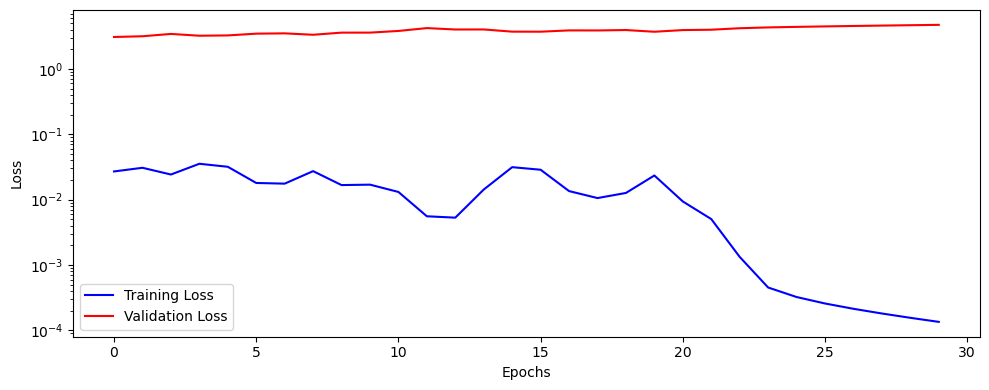

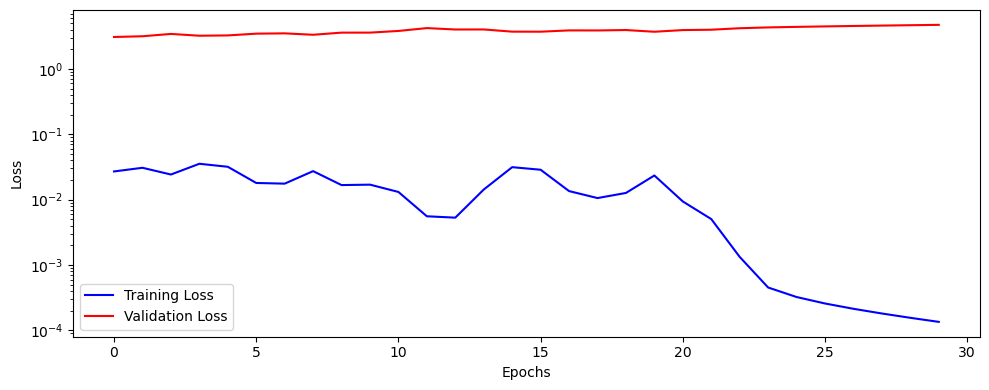

In [433]:
import matplotlib.pyplot as plt
trainer.plot_losses()